# 모바일 게임 A/B testing

## 문제 상황  

A게임사는 이번에 업데이트한 게임 Version에 대해서 적용 여부를 검토 중이다. 단순한 버그를 잡기위한 업데이트가 아닌 게임의 컨텐츠와 방식에  
대한 전반적인 내용이 변경되는 대대적인 업데이트라 반영하기 이전에 정말 효과가 있는지 검증해보고자 한다. 따라서 몇 명의 User에  
대해서 테스트해보고 효과가 있다면 Version up을 진행하고자 한다.

## 문제 해결 프로세스  

1. 문제정의

- Version 업데이트 적용여부 불분명

2. 기대효과

- Version 업데이트 확정 및 진행

3. 해결방안

- A/B test를 통해 Version up 유의미성 확인 및 업데이트 수행

4. 성과측정

- T test 결과, 유의미성 확인(P-value)

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('C:/Users/USER/Desktop/Practice Project - ETC/모바일 게임 A-B testing/모바일 게임 A-B testing.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [3]:
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

#### 변수 해석 3가지  

1. 결측치 존재 여부

- 전체 데이터에서 모든 변수에 결측치가 존재하지 않는다.

- 만약, 결측치의 개수가 전체 5% 미만이면 제거해도 좋다.

- 결측치를 대체하는 경우, object형태는 최빈값으로 대체하고, float64형태는 평균으로 대체하거나 KNN을 사용할 수 있다.

2. 데이터 타입 설명

- object64형태 1개, int64형태 2개, bool형태2개로 구성되어 있다.

3. 컬럼 설명

- user_id : 사용자ID
- version : 버젼
- sum_gamerounds : 총 플레이 횟수
- retention_1 : 1일 이후 재방문
- retention_7 : 7일 이후 재방문

In [4]:
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


우선 describe로 이상치를 판단하기 위해서는 mean, min, max 값을 확인하는 것이 좋다. mean과 min, mean과 max 값이 std에 비해 한참 차이가 난다면, 이상치가 있을 가능성이 높다

이러한 이상치를 정확히 판단하기 위해서는 아래와 같이 boxplot으로 시각화하여 보는 것이 정확하다

In [7]:
df_n = df.select_dtypes(exclude = ['object','bool'])

In [8]:
outlier = pd.melt(df_n, var_name = '이상치 탐색 변수', value_name = '이상치 탐색 값')
outlier

,이상치 탐색 변수,이상치 탐색 값
0,userid,116
1,userid,337
2,userid,377
3,userid,483
4,userid,488
...,...,...
180373,sum_gamerounds,97
180374,sum_gamerounds,30
180375,sum_gamerounds,28
180376,sum_gamerounds,51


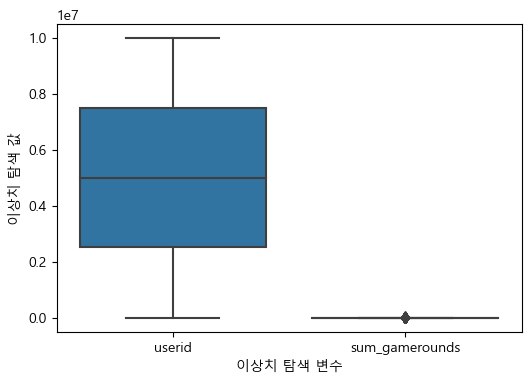

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
rc("font", family = 'Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize = (6,4))
sns.boxplot(x = '이상치 탐색 변수', y = '이상치 탐색 값', data = outlier)
plt.xticks(range(2), df_n.columns)
plt.show()

이상치를 탐색하기 위해서 수치형 변수만 선택해서 boxplot으로 시각화하였다. 이상치의 값이 연속적으로 나타나면, 보통 의미있는 값일 확률이 높기 때문에 따로 제거하거나 대체하지 않고, 눈에 띄는 이상치가 있을 경우에는 보통 제거하거나 대체하는 경우가 많다.(예를 들어, AGE 변수에 999값이 있다면 제거하거나 대체해야한다)

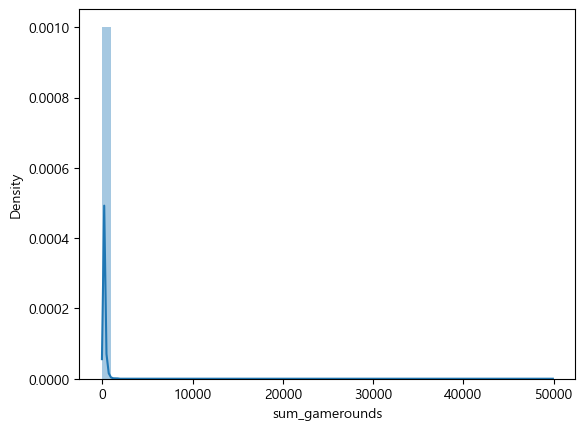

In [10]:
sns.distplot(df['sum_gamerounds']);

하지만, 총 플레이 횟수가 mean 대비 max가 상식적으로 이해하기 어렵기 때문에 상세한 탐색을 실시한다

In [11]:
df[df['sum_gamerounds'] > 5000]

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True


In [12]:
df = df[df['sum_gamerounds'] < 5000]
df.describe()

,userid,sum_gamerounds
count,9.018800e+04,90188.000000
mean,4.998397e+06,51.320253
std,2.883298e+06,102.682719
min,1.160000e+02,0.000000
25%,2.512211e+06,5.000000
50%,4.995804e+06,16.000000
75%,7.496461e+06,51.000000
max,9.999861e+06,2961.000000


위의 분포를 확인한 결과, 극단적으로 떨어진 값이 1개밖에 없기 때문에 이상치로 판단하고 제거해준다

1. A/B Test

- 웹페이지, 어플리케이션, 게임, 마케팅 등 서로 다른 2개의 상황에서의 반응률을 비교하여 어떤 상황이 더 효과적인지 판단하는 방법론

- 일반적으로 A가 기존 상황, B가 새로 변경할 상황

- P-value값이 0.05보다 작으면 대립가설을 채택


2. A/B Test 예시

- 타겟 마케팅 수행 후 실험군/대조군 반응률 GAP 분석

- 마케팅 채널(카카오톡채널, App push 등)에 따른 반응률 GAP 분석

- 페이지 탐색시 무한 스크롤 VS 페이지 section


3. A/B Test Process

- 1단계 : Test 설계, 비교하고자 하는 A/B를 정의


- 2단계 : 가설 수립 (ex. A와 B의 반응률은 차이가 없을 것이다)


- 3단계 : Pilot test(부분 테스트)를 통한 데이터 수집


- 4단계 : T test 및 결과 확인


- 5단계 : 유의하다면 B를 적용


4. A/B Test 구분

- 연속형 변수 : T test

- 범주형 변수 : Chi2 test(카이제곱)


5. A/B Test 주의사항

- A,B 집단이 동일한 특성을 가지고 있는지

- A,B 집단이 동일한 비율로 나뉘었는지(50 : 50)

- 1번이 아닌 2,3번 반복해서 정말 유의미한 결과인지

- 유의하다 = GAP(차이)이 유의하다

- 만약 결과가 유의하지 않다면 개선사항을 찾아보고 다시 1단계부터 재진행

## 반응률 분석

In [14]:
print("총 User 수 : ", df['userid'].count())

총 User 수 :  90188


In [15]:
print("gate_30 User 수 :", len(df[df['version'] == 'gate_30']))
print('gate_40 User 수 :', len(df[df['version'] == 'gate_40']))

gate_30 User 수 : 44699
gate_40 User 수 : 45489


In [16]:
import numpy as np
df['retention_1'] = np.where(df['retention_1'] == True, 1, 0)
df['retention_7'] = np.where(df['retention_7'] == True, 1, 0)
df.head(5)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


bool형태(True, False)로 된 retention 값을 계산이 가능한 1과 0으로 변경해준다

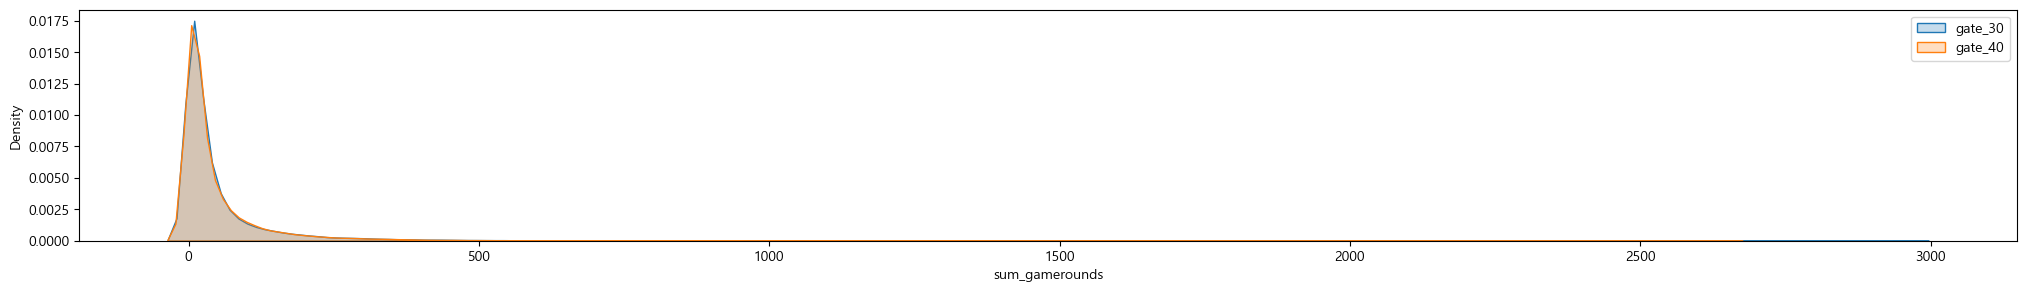

In [17]:
sns.kdeplot(df[df['version']=='gate_30']['sum_gamerounds'], shade=True, label='gate_30')
sns.kdeplot(df[df['version']=='gate_40']['sum_gamerounds'], shade=True, label='gate_40')
plt.gcf().set_size_inches(25, 3)
plt.legend()
plt.show()

총 플레이 횟수의 version별 분포를 비교해본다. 'shade=True'로 분포를 투명하게 만들어서 2개 분포를 비교할때 사용한다. 만약 분포가 비슷하면 차이를 파악하기 힘들기에 T test를 진행한다

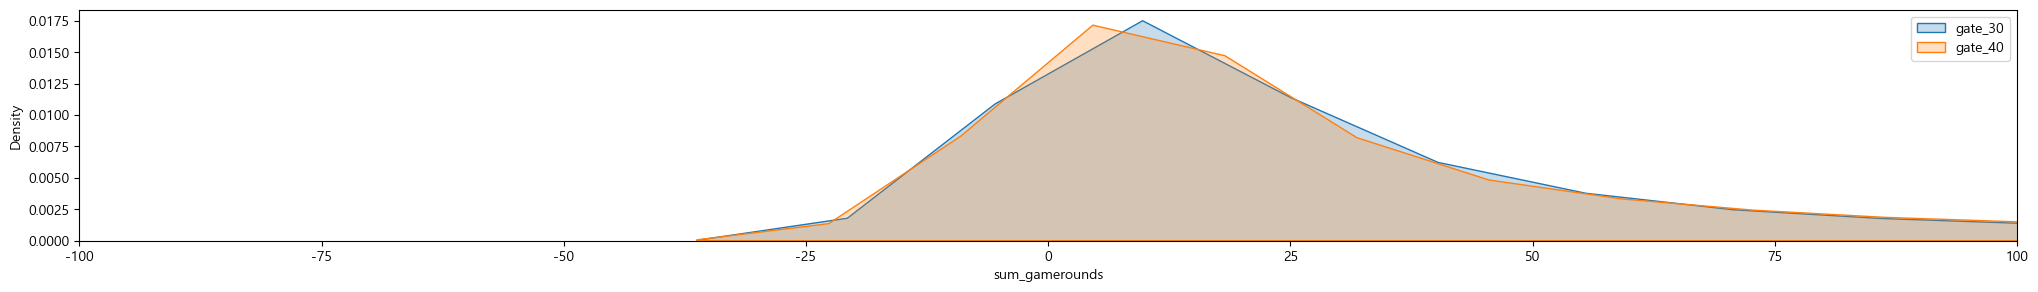

In [18]:
sns.kdeplot(df[df['version']=='gate_30']['sum_gamerounds'], shade=True, label='gate_30')
sns.kdeplot(df[df['version']=='gate_40']['sum_gamerounds'], shade=True, label='gate_40')
plt.gcf().set_size_inches(25, 3)
plt.legend()
plt.xlim(-100, 100)
plt.show()

총 플레이 횟수의 version별 분포를 xlim으로 조절해 확인한 결과, 위의 그래프상으로는 크게 차이가 있는지 확인이 불가능하다

In [19]:
print("gate_30 게임횟수 평균 : " ,df[df['version']=='gate_30']['sum_gamerounds'].mean())
print("gate_30 게임횟수 평균 : ", df[df['version']=='gate_40']['sum_gamerounds'].mean())

gate_30 게임횟수 평균 :  51.342110561757536
gate_30 게임횟수 평균 :  51.29877552814966


In [20]:
df[df['version']=='gate_30']['retention_1'].value_counts()

0    24665
1    20034
Name: retention_1, dtype: int64

In [22]:
print("gate_30 1일 후 재방문율 평균 : ", (20034 / (20034 + 24665))*100)

gate_30 1일 후 재방문율 평균 :  44.81979462627799


In [23]:
df[df['version']=='gate_40']['retention_1'].value_counts()

0    25370
1    20119
Name: retention_1, dtype: int64

In [24]:
print("gate_40 1일 후 재방문율 평균 : ", (20119 / (20119 + 25370))*100)

gate_40 1일 후 재방문율 평균 :  44.22827496757458


In [25]:
df[df['version']=='gate_30']['retention_7'].value_counts()

0    36198
1     8501
Name: retention_7, dtype: int64

In [26]:
print("gate_30 7일 후 재방문율 평균 : ", (8501 / (8501 + 36198))*100)

gate_30 7일 후 재방문율 평균 :  19.018322557551624


In [27]:
df[df['version']=='gate_40']['retention_7'].value_counts()

0    37210
1     8279
Name: retention_7, dtype: int64

In [28]:
print("gate_40 7일 후 재방문율 평균 : ", (8279 / (8279 + 37210))*100)

gate_40 7일 후 재방문율 평균 :  18.200004396667328


위의 비교결과를 확인한 결과, gate_30이 gate_40보다 총 User 수가 적지만 게임횟수/재방문율은 더 높은 것을 알 수 있다

In [30]:
df.groupby('version')[['sum_gamerounds', 'retention_1', 'retention_7']].agg(['mean', 'count', 'sum'])


df_pivot = pd.DataFrame(df.groupby('version')[['sum_gamerounds', 'retention_1', 'retention_7']].agg(['mean', 'count', 'sum']).reset_index())

df_pivot.columns = ['version', 'sum_gamerounds_mean', 'sum_gamerounds_count', 'sum_gamerounds_sum',
                    'retention_1_mean', 'retention_1_count', 'retention_1_sum', 
                    'retention_7_mean', 'retention_7_count', 'retention_7_sum']

df_pivot = df_pivot[['version', 'sum_gamerounds_mean', 'retention_1_count', 'retention_1_sum', 'retention_7_count', 'retention_7_sum']]
df_pivot

,version,sum_gamerounds_mean,retention_1_count,retention_1_sum,retention_7_count,retention_7_sum
0,gate_30,51.342111,44699,20034,44699,8501
1,gate_40,51.298776,45489,20119,45489,8279


연속형 변수는 평균, 범주형 변수는 반응률로 사전데이터를 준비하기 위해 mean/count/sum을 만들어주고 reset_index로 multi index를 제거하며 컬럼을 재정비한다  

단, 연속형 변수는 평균값이 아닌 기본값을 입력해도 내부적으로 평균값을 산출해준다

In [31]:
df_pivot['retention_1_ratio'] = df_pivot['retention_1_sum'] / df_pivot['retention_1_count']
df_pivot['retention_7_ratio'] = df_pivot['retention_7_sum'] / df_pivot['retention_7_count']
df_pivot

,version,sum_gamerounds_mean,retention_1_count,retention_1_sum,retention_7_count,retention_7_sum,retention_1_ratio,retention_7_ratio
0,gate_30,51.342111,44699,20034,44699,8501,0.448198,0.190183
1,gate_40,51.298776,45489,20119,45489,8279,0.442283,0.182000


범주형 변수 반응률을 계산하여 ratio를 생성해준다

In [33]:
df_pivot.columns

Index(['version', 'sum_gamerounds_mean', 'retention_1_count',
       'retention_1_sum', 'retention_7_count', 'retention_7_sum',
       'retention_1_ratio', 'retention_7_ratio'],
      dtype='object')

In [34]:
df_pivot[['version', 'sum_gamerounds_mean', 'retention_1_ratio', 'retention_7_ratio']]

,version,sum_gamerounds_mean,retention_1_ratio,retention_7_ratio
0,gate_30,51.342111,0.448198,0.190183
1,gate_40,51.298776,0.442283,0.182000


연속형 변수는 평균, 범주형 변수는 반응률로 사전데이터 준비를 완료한다

## T-test 활용 A/B testing

In [37]:
from scipy import stats
tstat, pvalue = stats.bartlett(df[df['version'] == 'gate_30']['sum_gamerounds'], df[df['version'] == 'gate_40']['sum_gamerounds'])
print("P-value:", round(pvalue,3))

P-value: 0.011


- 귀무가설(H0) = A, B는 분산이 동일하다.  


- 대립가설(H1) = A, B는 분산이 동일하지 않다.


일반적으로 귀무가설은 "차이가 없다(동일하다)"로 설정하고 대립가설은 "차이가 있다(동일하지 않다)"로 설정한다  

위의 P-value값이 0.05보다 작으므로 대립가설을 채택하게 된다. 따라서 등분산성을 만족하지 않으므로 두 데이터에 분산이 동일하지 않다

In [38]:
tstat, pvalue = stats.ttest_ind(df[df['version'] == 'gate_30']['sum_gamerounds'], df[df['version'] == 'gate_40']['sum_gamerounds'], equal_var=False)
print("P-value:", round(pvalue,3))

P-value: 0.949


equal_var

- True : 등분산성 만족

- False : 등분산성 만족 x

- 귀무가설(H0) = A와 B의 게임횟수 평균이 같다.


- 대립가설(H1) = A와 B의 게임횟수 평균이 다르다.


위의 P-value값이 0.05보다 크므로 귀무가설을 채택하게 된다. 따라서 A와 B의 게임횟수 평균이 같은 것으로 유의하지 않은 T test 결과가 나왔다(sum_gamerounds = 게임횟수)  

In [39]:
df_pivot_1 = df_pivot[['version', 'retention_1_count', 'retention_1_sum']]
df_pivot_1

,version,retention_1_count,retention_1_sum
0,gate_30,44699,20034
1,gate_40,45489,20119


In [40]:
df_pivot_1['retention_1_no'] = df_pivot_1['retention_1_count'] - df_pivot_1['retention_1_sum']
df_pivot_1 = df_pivot_1[['retention_1_sum', 'retention_1_no']]
df_pivot_1.columns = ['yes', 'no']
df_pivot_1

,yes,no
0,20034,24665
1,20119,25370


반응한 고객과 반응하지 않은 고객에 대한 관찰 빈도가 필요하기에 yes, no로 만들어준다

In [41]:
chi2, p_value, df, _ = stats.chi2_contingency(df_pivot_1)
print("P-value:",p_value)

P-value: 0.07500999897705693


- 귀무가설(H0) = A와 B의 리텐션 반응률 차이가 없다.  


- 대립가설(H1) = A와 B의 리텐션 반응률 차이가 있다.


위의 P-value값이 0.05보다 크므로 귀무가설을 채택하게 된다. 따라서 A와 B의 리텐션 반응률 차이가 없는 것으로 유의하지 않은 Chi2 test 결과가 나왔다(retention_1 = 1일 이후 재방문)

In [42]:
df_pivot_2 = df_pivot[['version', 'retention_7_count', 'retention_7_sum']]
df_pivot_2

,version,retention_7_count,retention_7_sum
0,gate_30,44699,8501
1,gate_40,45489,8279


In [43]:
df_pivot_2['retention_7_no'] = df_pivot_2['retention_7_count'] - df_pivot_2['retention_7_sum']
df_pivot_2 = df_pivot_2[['retention_7_sum', 'retention_7_no']]
df_pivot_2.columns = ['yes', 'no']
df_pivot_2

,yes,no
0,8501,36198
1,8279,37210


반응한 고객과 반응하지 않은 고객에 대한 관찰 빈도가 필요하기에 yes, no로 만들어준다

In [44]:
chi2, p_value, df, _ = stats.chi2_contingency(df_pivot_2)
print("P-value:",p_value)

P-value: 0.0016391259678654423


- 귀무가설(H0) = A와 B의 리텐션 반응률 차이가 없다.  


- 대립가설(H1) = A와 B의 리텐션 반응률 차이가 있다.


위의 P-value값이 0.05보다 작으므로 대립가설을 채택하게 된다. 따라서 A와 B의 리텐션 반응률 차이가 있는 것으로 유의한 Chi2 test 결과가 나왔다(retention_7 = 7일 이후 재방문)

In [45]:
print('sum_gamerounds_diff :',df_pivot['sum_gamerounds_mean'].iloc[0] - df_pivot['sum_gamerounds_mean'].iloc[1])
print('retention_1_diff :', df_pivot['retention_1_ratio'].iloc[0] - df_pivot['retention_1_ratio'].iloc[1])
print('retention_7_diff :', df_pivot['retention_7_ratio'].iloc[0] - df_pivot['retention_7_ratio'].iloc[1])

sum_gamerounds_diff : 0.04333503360787461
retention_1_diff : 0.005915196587034155
retention_7_diff : 0.00818318160884296


- gate_30이 gate_40 대비 +0.04 더 많은 게임플레이횟수를 보였으나 우연에 의해 차이가 발생했을 확률이 높다(유의성이 없다)


- gate_30이 gate_40 대비 +0.5% 더 많은 1일 이후 재방문율을 보였고, 유의성이 없다


- gate_30이 gate_40 대비 +0.8% 더 많은 7일 이후 재방문율을 보였고, 신뢰수준 99% 이상으로 유의성이 있다

T test 결과

- gate_30이 gate_40 대비 게임플레이횟수, 1일 이후 재방문율이 높게 나왔지만, 유의하지 않은 결과가 나왔기 때문에 랜덤으로 차이가 발생했을 것이다


- gate_30이 gate_40 대비 7일 이후 재방문율이 높게 나왔고, 유의한 결과가 나왔기 때문에 GAP(차이)이 발생한 것이 사실이다


성과측정은 유의성을 확인한 것으로 완료되었고, 게임 회사의 입장을 2가지로 생각해볼 수 있다

1번 : 7일 이후 재방문율은 게임 회사의 중요하지 않은 부분이니 일단 업데이트 진행

2번 : 7일 이후 재방문율은 게임 회사의 메인 업데이트이며 필수적인 부분이니 업데이트 다시 생각